<a href="https://colab.research.google.com/github/MonishSoundarRaj/data_check_generator/blob/main/Other_plots_for_JSSPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

df_real = pd.read_csv("theta_data_training.csv")
df_syn = pd.read_csv("synthetic_data_ctgan_theta.csv")

In [2]:
from matplotlib import ticker as mticker
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import seaborn
import pandas as pd
from datetime import datetime
from collections import Counter, defaultdict
import json

def analyze_attribute_per(u, data):
    rows = list(data.groupby(u).count().sort_values(by="job", ascending=False).index[:10])
    job_counts = list(data.groupby(u).count().sort_values(by="job", ascending=False)["job"][:10])
    sum_of_node_hour = [data.groupby(u).sum()["node_hour"].loc[i]//3600 for i in rows]
    mean_nodes = [data.groupby(u).mean()["node_num"].loc[i] for i in rows]
    mean_run_time = [data.groupby(u).mean()["run_time"].loc[i] for i in rows]
    temp_df = pd.DataFrame(list(zip(rows, job_counts, sum_of_node_hour, mean_nodes, mean_run_time)),
                           columns=[u, "job_count", "sum_of_node_hour", "mean_nodes", "mean_run_time"])
    return temp_df

def analyze_attribute_per_ml(u, data, status=["Pass","Failed","Killed"]):
    rows = list(data.groupby(u).count().sort_values(by="job", ascending=False).index[:10])
    job_counts = list(data.groupby(u).count().sort_values(by="job", ascending=False)["job"][:10])
    sum_of_node_hour = [data.groupby(u).sum()["node_hour"].loc[i]//3600 for i in rows]
    mean_nodes = [data.groupby(u).mean()["node_num"].loc[i] for i in rows]
    mean_run_time = [data.groupby(u).mean()["run_time"].loc[i] for i in rows]
    st0_run_time = [data.groupby([u, "state"]).mean()["run_time"].loc[i].get(status[0],0) for i in rows]
    st1_run_time = [data.groupby([u, "state"]).mean()["run_time"].loc[i].get(status[1],0) for i in rows]
    st2_run_time = [data.groupby([u, "state"]).mean()["run_time"].loc[i].get(status[2],0) for i in rows]

    temp_df = pd.DataFrame(list(zip(rows, job_counts, sum_of_node_hour, mean_nodes, mean_run_time, st0_run_time,
                                   st1_run_time, st2_run_time )),
                           columns=[u, "job_count", "sum_of_node_hour", "mean_nodes", "mean_run_time",
                                    "mean_run_time ({})".format(status[0]),
                                   "mean_run_time ({})".format(status[1]),
                                   "mean_run_time ({})".format(status[2])])
    return temp_df

def plot_attribute_per_ml(u, data, state="state", status=["Pass","Failed","Killed"],all_user=False):
    plt.style.use("default")
    rows = list(data.groupby(u).count().sort_values(by="job", ascending=False).index[:3])
    # rows = list(data.groupby(u).sum().sort_values(by="job", ascending=False).index[:3])
    # rows = list(data.groupby(u).sum().sort_values(by="node_hour", ascending=False).index[:3])
    if all_user:
        mean_run_time = [data["run_time"]]
        st0_run_time = [data.groupby([state])["run_time"].apply(list).get(status[0],0)]
        st1_run_time = [data.groupby([state])["run_time"].apply(list).get(status[1],0)]
        st2_run_time = [data.groupby([state])["run_time"].apply(list).get(status[2],0)]
        fig, axes = plt.subplots(1, 1, figsize=(4, 3))

        for index, i in enumerate(zip(st0_run_time, st1_run_time, st2_run_time)):
            k = [np.log10(np.array(j)+1) for j in i]
            sns.violinplot(data=k,ax=axes, scale="width")

        ax = axes
        ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
        ymin, ymax = ax.get_ylim()
        tick_range = np.arange(np.floor(ymin), ymax)
        ax.yaxis.set_ticks(tick_range)
        ax.yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
        ax.yaxis.grid(True)
        ax.set_xticks([y for y in range(3)])
        ax.set_xticklabels([ "Pass", "Failed", "Killed"], fontsize=24)
        ax.set_ylabel('Job Run time (s)', fontsize=20)
    else:
        mean_run_time = [data.groupby(u)["run_time"].apply(list).loc[i] for i in rows]
        st0_run_time = [data.groupby([u, state])["run_time"].apply(list).loc[i].get(status[0],0) for i in rows]
        st1_run_time = [data.groupby([u, state])["run_time"].apply(list).loc[i].get(status[1],0) for i in rows]
        st2_run_time = [data.groupby([u, state])["run_time"].apply(list).loc[i].get(status[2],0) for i in rows]
        fig, axes = plt.subplots(1, 3, figsize=(12, 3))

        for index, i in enumerate(zip(st0_run_time, st1_run_time, st2_run_time)):
            k = [np.log10(np.array(j)+1) for j in i]
            sns.violinplot(data=k,ax=axes[index%3], scale="width")

        for index, ax in enumerate(axes.flatten()):
            ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
            ymin, ymax = ax.get_ylim()
            tick_range = np.arange(np.floor(ymin), ymax)
            ax.yaxis.set_ticks(tick_range)
            ax.yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True,)
            ax.yaxis.grid(True)
            ax.set_xticks([y for y in range(3)])
            ax.set_xticklabels([ "Pass", "Failed", "Killed"], fontsize=15)
            ax.set_xlabel('User '+str(index+1), fontsize=20)

            if index == 0:
                ax.set_ylabel('Job Run time (s)', fontsize=20)
    plt.show()

Real Theta


<ipython-input-2-04122e33fcc9>:53: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=k,ax=axes, scale="width")


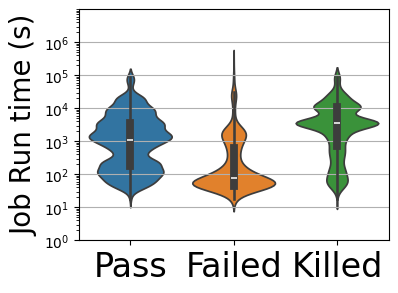

In [3]:
print("Real Theta")
plot_attribute_per_ml("user", data=df_real, state="new_status", all_user=True)

<ipython-input-2-04122e33fcc9>:53: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=k,ax=axes, scale="width")


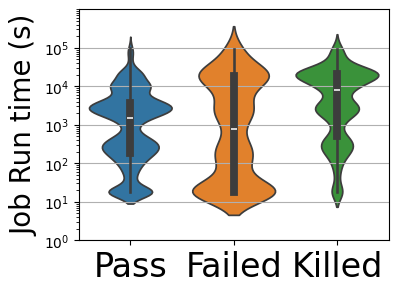

In [4]:
plot_attribute_per_ml("user", data=df_syn, state="new_status", all_user=True)

In [5]:
print("syn_data")
print("----------------------------")
status_count = df_syn.groupby("new_status").count()
pass_count = status_count.loc["Pass", "job"]
failed_count = status_count.loc["Failed", "job"]
killed_count = status_count.loc["Killed", "job"]

print("Pass:", pass_count)
print("Failed:", failed_count)
print("Killed:", killed_count)

syn_data
----------------------------
Pass: 10396
Failed: 1657
Killed: 2947


In [6]:
print("real_data")
print("--------------------------")
status_count = df_real.groupby("new_status").count()
pass_count = status_count.loc["Pass", "job"]
failed_count = status_count.loc["Failed", "job"]
killed_count = status_count.loc["Killed", "job"]

print("Pass:", pass_count)
print("Failed:", failed_count)
print("Killed:", killed_count)

real_data
--------------------------
Pass: 9245
Failed: 1215
Killed: 4540


In [7]:
# Assuming the first job submit_time is given as 1539300 (Unix timestamp)
first_submit_time = 1668693697

# Since the interval is the difference between subsequent times,
# we should ensure that the first interval is 0 because it has no previous job.
df_syn.loc[0, 'interval'] = 0

# Convert intervals back to submit times, cumsum() function is used to create a cumulative sum of interval
df_syn['submit_time'] = df_syn['interval'].cumsum() + first_submit_time

In [8]:
# Assuming the first job submit_time is given as 1539300 (Unix timestamp)
first_submit_time = 1668693697

# Since the interval is the difference between subsequent times,
# we should ensure that the first interval is 0 because it has no previous job.
df_real.loc[0, 'interval'] = 0

# Convert intervals back to submit times, cumsum() function is used to create a cumulative sum of interval
df_real['submit_time'] = df_real['interval'].cumsum() + first_submit_time

In [9]:
def get_time_of_day(time, timestamp=True):
    if timestamp:
        time = datetime.fromtimestamp(time)
    else:
        time = datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    return (time.hour + (time.minute>30))%24, datetime.strftime(time, '%Y-%m-%d')

def get_day_of_week(time):
    time = datetime.fromtimestamp(time)
    return time.isocalendar()[2], time.isocalendar()[1]

def plot_time_submit(submit_time, xlabel, ylabel="Number of Submitted Jobs", week=False, marker="o", color = "red"):
    if week == True:
        time, days = list(zip(*[get_time_of_day(i) for i in submit_time]))
        dd = Counter()
        for i in time:
            dd[i] += 1
        keys = sorted(dd.keys())
        n = len(set(days))
    else:
        days, weeks = list(zip(*[get_day_of_week(i) for i in submit_time]))
        dd = Counter()
        for i in days:
            dd[i] += 1
        keys = sorted(dd.keys())
        n = len(set(weeks))
    plt.plot(keys, [np.array(dd[j])/n for j in keys], marker=marker, linewidth=3, markersize=12, color = color)


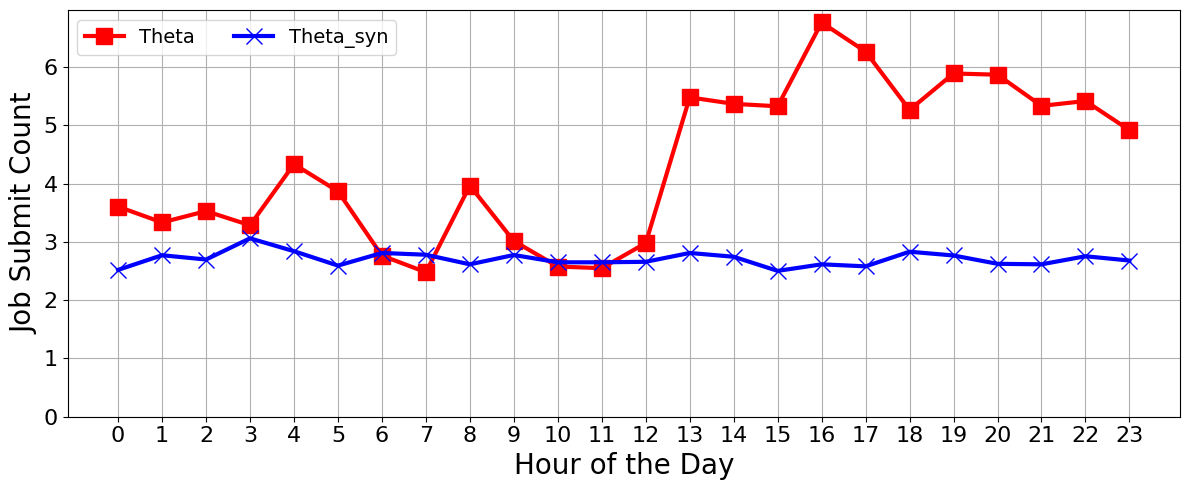

In [10]:
plt.figure(figsize=(12,5))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plot_time_submit(df_real["submit_time"], xlabel="Hour of the Day", week=True, marker="s", color = "red")
plot_time_submit(df_syn["submit_time"], xlabel="Hour of the Day", week=True, marker="x", color = "blue")
plt.xlabel("Hour of the Day", fontsize=20)
plt.ylabel("Job Submit Count", fontsize=20)
plt.ylim(bottom=0)
plt.tight_layout()
plt.grid(True)
plt.legend(["Theta", "Theta_syn"],  prop={'size': 14}, ncol = 2)
plt.xticks(range(0, 24, 1))
plt.rc('legend',fontsize=20)